<a href="https://colab.research.google.com/github/cxbxmxcx/Evolutionary-Deep-Learning/blob/main/EDL_5_GS_HPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
#@title Defining Imports
#numpy
import numpy as np
#PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
#plotting
from matplotlib import pyplot as plt
from IPython.display import clear_output
#for performance timing
import time
#utils
import random
import types
from itertools import cycle
from sklearn.model_selection import ParameterGrid

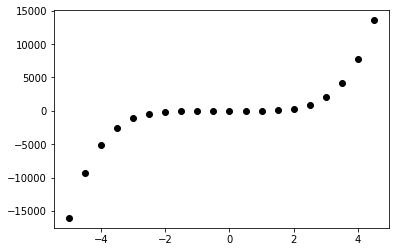

In [ ]:
#@title Create and Render the Target Data
def function(x):
  return (2*x + 3*x**2 + 4*x**3 + 5*x**4 + 6*x**5 + 10) 

data_min = -5
data_max = 5
data_step = .5
Xi = np.reshape(np.arange(data_min, data_max, data_step), (-1, 1))
yi = function(Xi)
inputs = Xi.shape[1]
yi = yi.reshape(-1, 1)
plt.plot(Xi, yi, 'o', color='black')

In [ ]:
#@title Define the Model
class Net(nn.Module):
  def __init__(self, inputs, middle):
    super().__init__()
    self.fc1 = nn.Linear(inputs,middle)    
    self.fc2 = nn.Linear(middle,middle)    
    self.out = nn.Linear(middle,1)
  def forward(self, x):
    x = F.relu(self.fc1(x))     
    x = F.relu(self.fc2(x))    
    x = self.out(x)
    return x

In [ ]:
#@title Define HyperparametersGrid Class
class HyperparametersGrid(object):
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs) 
    self.hparms = [d for d in self.__dict__]   
    self.grid = {}   
    if isinstance(self.__dict__[self.hparms[0]], types.GeneratorType):        
      self.grid = self.create_grid()
      self.grid_size = len(self.grid)      
        
  def __str__(self):
    out = ""
    for d in self.hparms:
      ds = self.__dict__[d]
      out += f"{d} = {ds}\n"
    return out 

  def create_grid(self):
    grid = {}
    for d in self.hparms:
      v,len = next(self.__dict__[d])
      row = []
      for i in range(len):
        v,_ = next(self.__dict__[d])
        row.append(v)
      grid[d] = row
    grid = ParameterGrid(grid)    
    return grid  

  def next(self):
    for hp in self.grid:
      yield HyperparametersGrid(**hp)      

def grid(min, max, step):  
  grid = cycle(np.arange(min, max, step))
  len = (max-min) / step
  for i in grid:
    yield i, int(len)

def grid_int(min, max, step): 
  grid = cycle(range(min, max, step))
  len = (max-min) / step
  for i in grid:
    yield i, int(len)

# Create the HyperparametersGrid Object

In [ ]:
#@title Populate the HyparameterGrid 
hp = HyperparametersGrid(
  middle_layer = grid_int(12, 36, 4),
  learning_rate = grid(3.5e-02,3.5e-01, 3.5e-02),
  batch_size = grid_int(4, 16, 4),    
  epochs = grid_int(300,400,25)  
)

cuda = True if torch.cuda.is_available() else False
print("Using CUDA" if cuda else "Not using CUDA")
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

print(hp.grid_size)

Using CUDA
576


# Create a Training Function

275.4368591308594


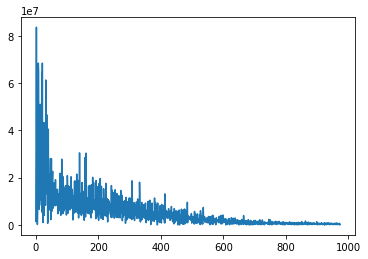

In [ ]:
#@title Wrapper Function
def train_function(hp, best):
  hp = next(hp.next())

  X = np.reshape(
      np.arange(
          data_min, 
          data_max, 
          data_step)
      , (-1, 1))
  y = function(X)
  inputs = X.shape[1]
  
  tensor_x = torch.Tensor(X) # transform to torch tensor
  tensor_y = torch.Tensor(y)
  
  dataset = TensorDataset(tensor_x,tensor_y) # create your datset
  dataloader = DataLoader(dataset, batch_size= hp.batch_size, shuffle=True) # create your dataloader

  model = Net(inputs, hp.middle_layer)
  loss_fn = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=hp.learning_rate)
  if cuda:
    model.cuda()
    loss_fn.cuda()
  
  history=[]  
  start = time.time()
  for i in range(hp.epochs):        
    for X, y in iter(dataloader):
      # wrap the data in variables
      x_batch = Variable(torch.Tensor(X).type(Tensor))
      y_batch = Variable(torch.Tensor(y).type(Tensor))                   
      # forward pass
      y_pred = model(x_batch)        
      # compute and print loss
      loss = loss_fn(y_pred, y_batch)  
      ll = loss.data
      history.append(ll)                   
      # reset gradients
      optimizer.zero_grad()        
      # backwards pass
      loss.backward()        
      # step the optimizer - update the weights
      optimizer.step()  
  end = time.time() - start
  return end, history, model, hp

best = float("inf")
span, history, model, hp_out = train_function(hp, best)
plt.plot(history)
print(min(history).item())

# Automate the HPO

Run: 210/576, Fitness: 290.49078369140625


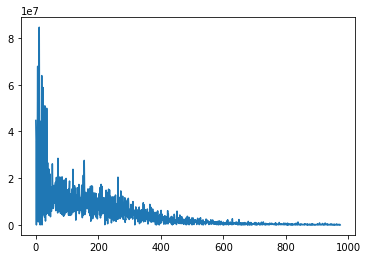

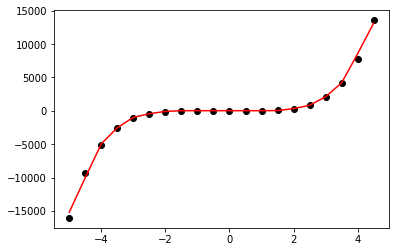

batch_size = 8
epochs = 325
learning_rate = 0.07
middle_layer = 16



In [ ]:
#@title Run the HPO
runs = hp.grid_size
best = float("inf")
for i in range(runs):
  span, history, model, hp_out = train_function(hp, best)
  fitness = history[-1].item() 
  if fitness < best:
    best = fitness  
    clear_output()
    print(f"Run: {i}/{runs}, Fitness: {fitness}")
    plt.plot(history)
    plt.show()
    plt.plot(Xi, yi, 'o', color='black')
    y_ = model(torch.Tensor(Xi).type(Tensor))
    plt.plot(Xi,y_.detach().cpu().numpy(), 'r')
    plt.show()
    print(hp_out)    
    time.sleep(1)
